<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/i_jepa_aav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

beautifulminnd_aav_spectrogram_path = kagglehub.dataset_download('beautifulminnd/aav-spectrogram')

print('Data source import complete.')


In [2]:
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import Counter
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import time
from tqdm import tqdm
import torch
import timm
import matplotlib.pyplot as plt
import copy
from torchvision.models import vit_b_16
from collections import Counter
from tqdm import tqdm # for progress bar
import random
import os

In [3]:
import os
print("Number of CPU cores:", os.cpu_count())


Number of CPU cores: 8


In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define base directory and file name for saving the classifier checkpoint.
base_dir = "/kaggle/working/AAVDATASET/spectrogram"
base_dir = '/content/drive/MyDrive/AAVDATASET/spectrogram'

In [6]:
data_dir = '/kaggle/input/aav-spectrogram/spectrogram'
data_dir = '/content/drive/MyDrive/AAVDATASET/spectrogram/dataset'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
import os
import pickle
import torch
import random
from torch.utils.data import Dataset
from tqdm import tqdm

# Set device for GPU acceleration if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(
        context_block.unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(0)

    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(
            target_block.unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

def process_sample(sample, context_scale, target_scale, num_targets):
    # Unpack sample: sample is ((img, label), image_path)
    (img, label), image_path = sample
    # Move image to GPU if available.
    img = img.to(device)
    context_block, target_blocks, _, _ = extract_blocks(img, context_scale, target_scale, num_targets)
    # Bring results back to CPU before caching.
    return (context_block.cpu(), target_blocks.cpu(), label, image_path)

class PrecomputedIJEPADataset(Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4, cache_file=None):
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            # Load precomputed data from disk.
            with open(cache_file, 'rb') as f:
                self.data = pickle.load(f)
        else:
            # Create a list of samples along with their original image paths (if available) using a progress bar.
            if hasattr(base_dataset, 'samples'):
                base_samples = [
                    (base_dataset[i], base_dataset.samples[i][0])
                    for i in tqdm(range(len(base_dataset)), desc="Loading samples")
                ]
            else:
                base_samples = [
                    (sample, None) for sample in tqdm(base_dataset, desc="Loading samples")
                ]

            # Process samples sequentially with a progress bar.
            self.data = []
            for sample in tqdm(base_samples, desc="Processing samples"):
                result = process_sample(sample, context_scale, target_scale, num_targets)
                self.data.append(result)

            if cache_file:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [8]:


# Timing the loading of the dataset and DataLoader
cache_path = os.path.join(base_dir,"precomputed_fulldataset_aav.pkl")
print(cache_path)
start_time = time.time()
dataset_aav_ijepa = PrecomputedIJEPADataset(dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
dataloader_aav_ijepa = DataLoader(dataset_aav_ijepa, batch_size=32, shuffle=True)
end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - end_time_train_ijepa_dataset:.4f} seconds")


/content/drive/MyDrive/AAVDATASET/spectrogram/precomputed_fulldataset_aav.pkl
Time taken to load dataset: 48.3091 seconds and DataLoader: 0.0003 seconds


In [9]:
total_batches = len(dataloader_aav_ijepa)
print("Total number of batches:", total_batches)

Total number of batches: 110


In [11]:
num_images = len(dataset_aav_ijepa)
print(f"Number of images in the dataset: {num_images}")

Number of images in the dataset: 3513


In [11]:
# Each sample in dataset.imgs is a tuple (image_path, class_index)
#class_counts = Counter(label for _, label in dataset_aav_ijepa.imgs)
#print("Total images per class:", class_counts)

# Optionally, map indices back to class names using dataset.class_to_idx
idx_to_class = {v: k for k, v in dataset_aav_ijepa.class_to_idx.items()}
for idx, count in class_counts.items():
    print(f"Class '{idx_to_class[idx]}': {count} images")

AttributeError: 'PrecomputedIJEPADataset' object has no attribute 'class_to_idx'

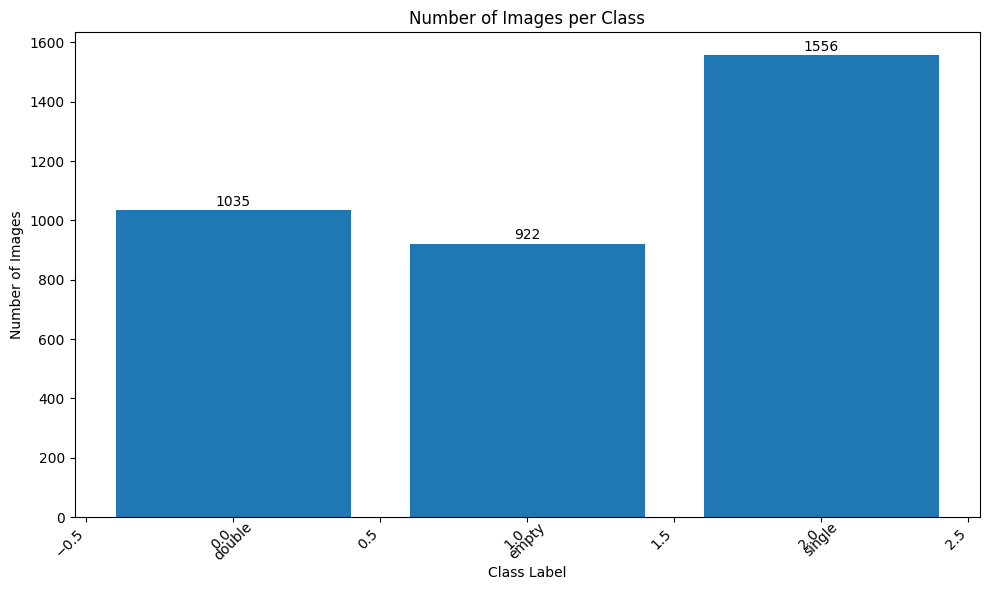

In [12]:
# Extract the labels from the dataset:
labels = [sample[2] for sample in dataset_aav_ijepa.data]

# Count the occurrences of each label using Counter:
class_counts = Counter(labels)

# Get the class labels and their corresponding counts:
class_labels, counts = zip(*class_counts.items())

# Create the bar graph:
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add text labels above the bars:
for i, count in enumerate(counts):
    plt.text(class_labels[i], count + 5,  # Adjust vertical position as needed
             str(count), ha='center', va='bottom')

# Add text labels for class names below the x-axis:
for i, label in enumerate(class_labels):
    plt.text(label, -10,  # Adjust vertical position as needed
             dataset.classes[label], ha='center', va='top', rotation=45)  # Assuming dataset has 'classes' attribute

plt.show()

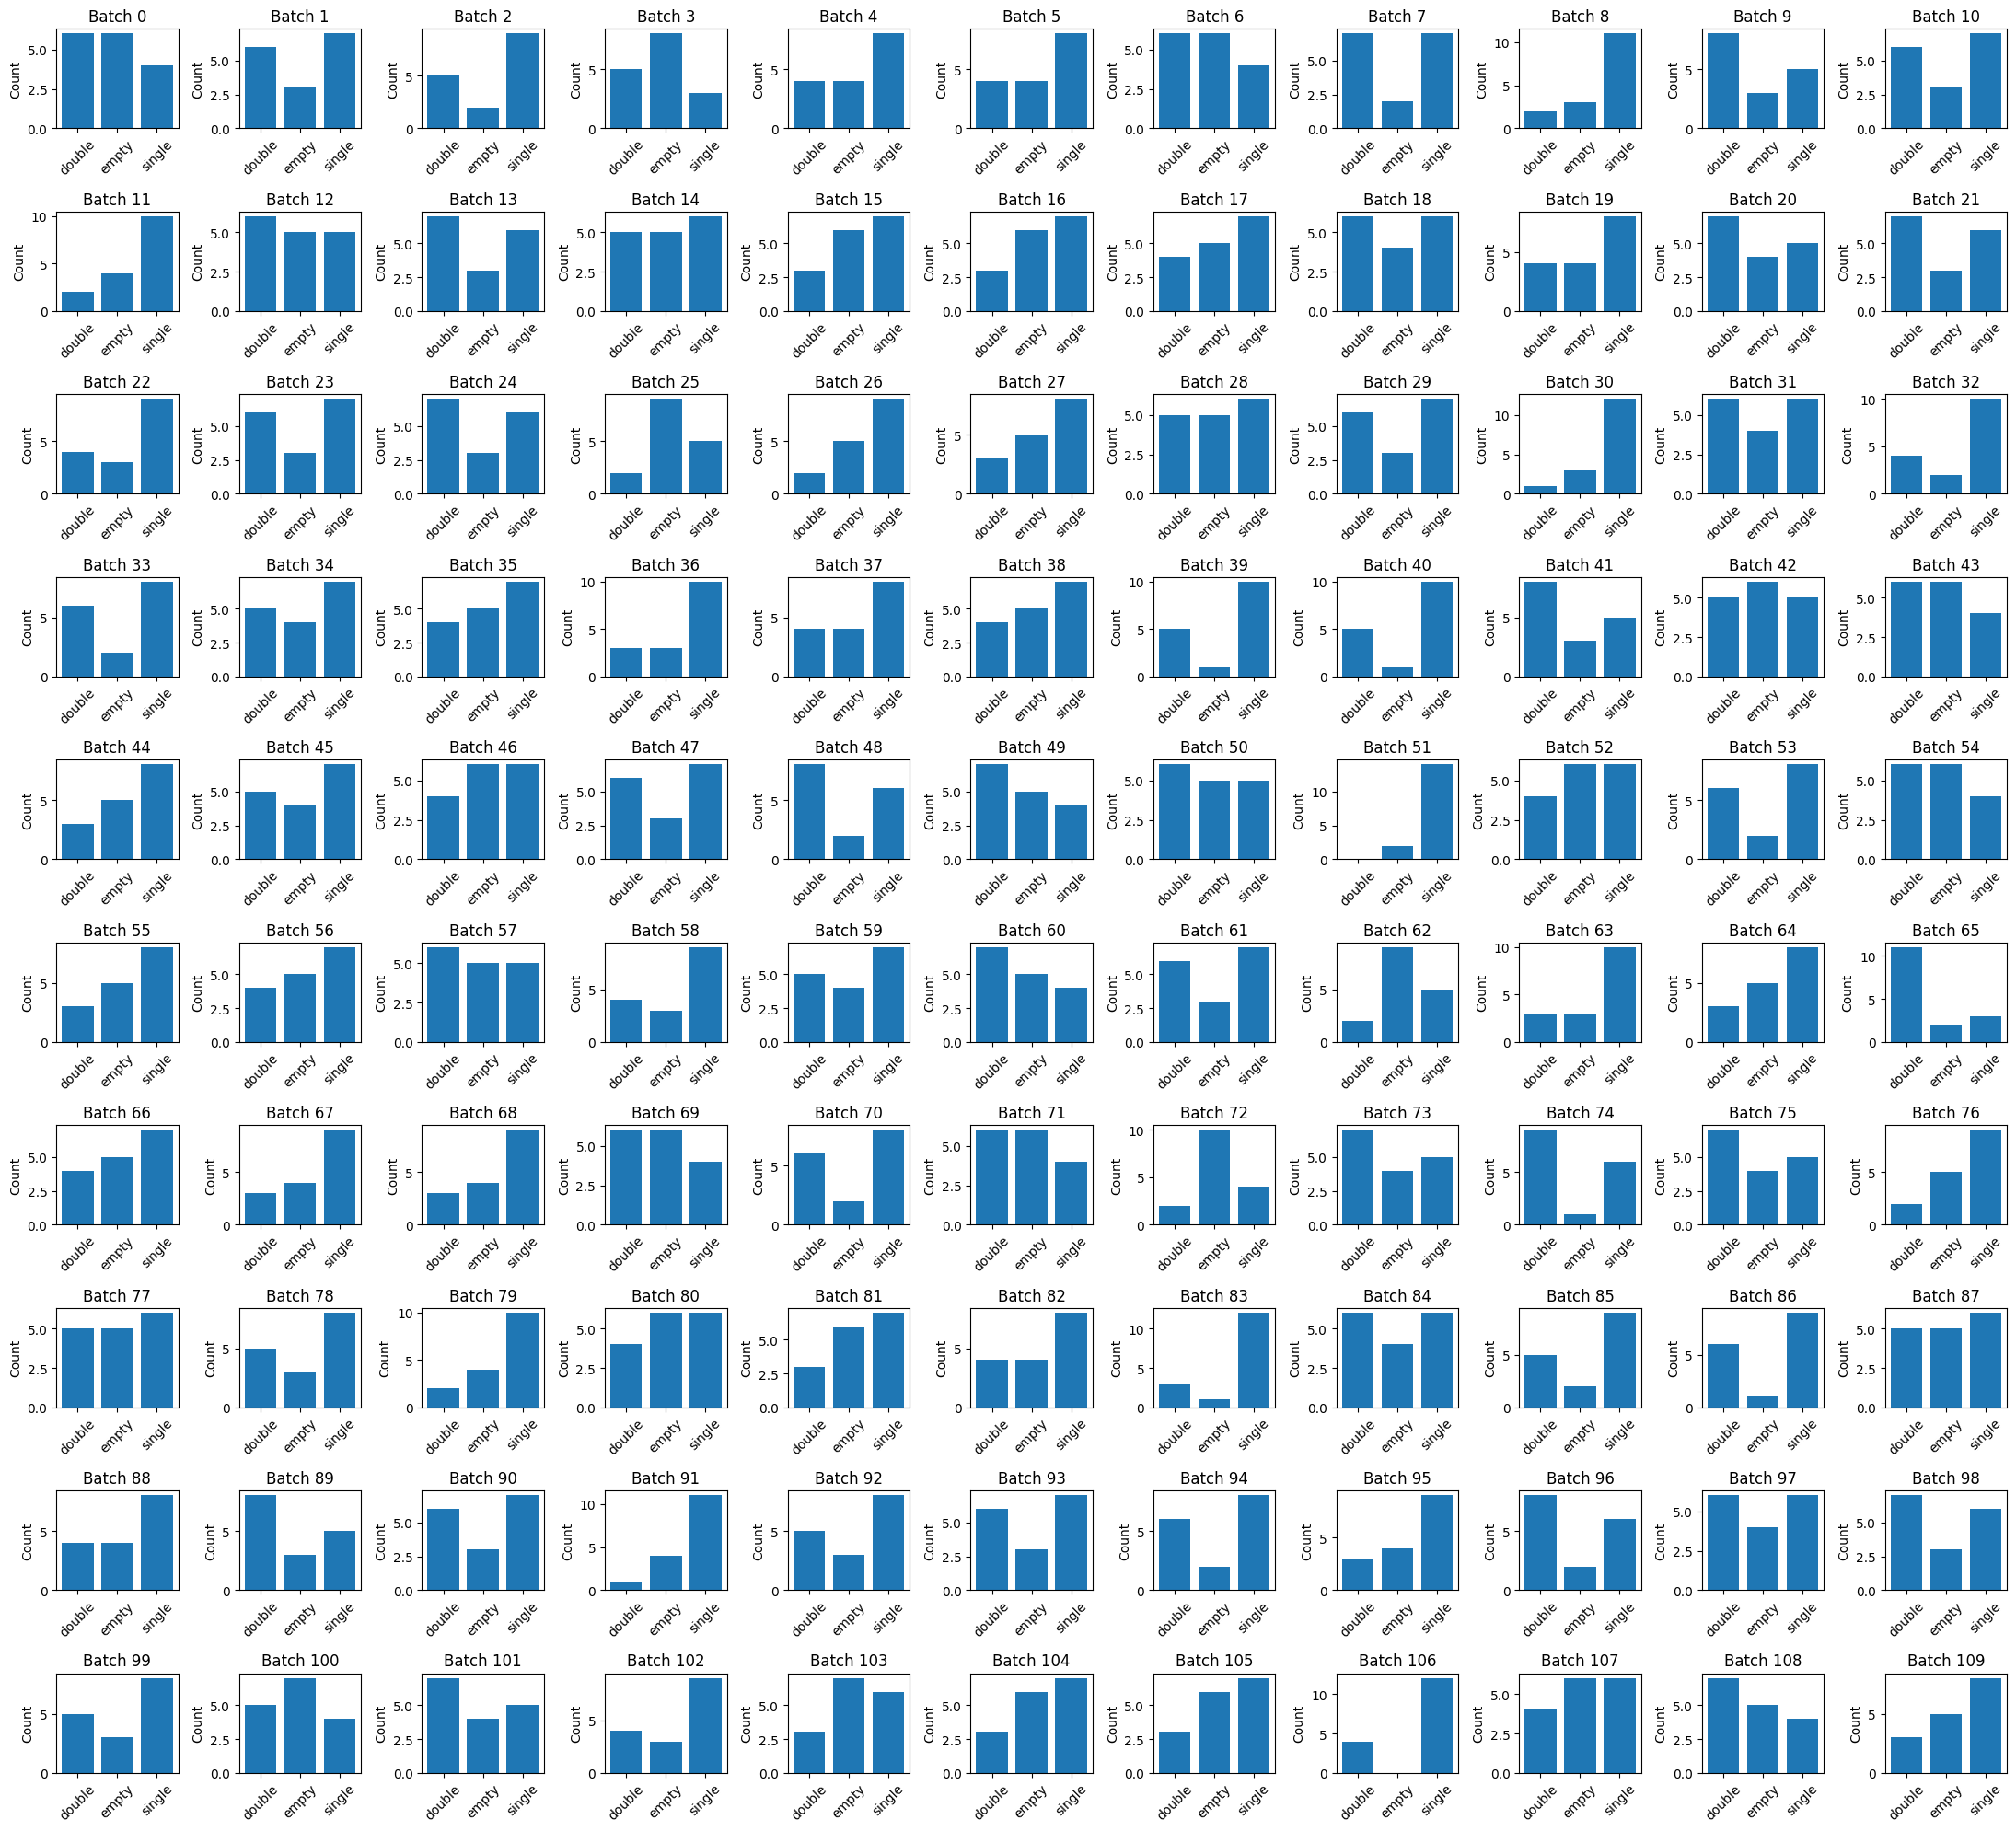

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Set the number of rows and columns for the grid
num_rows = 10
num_cols = 11
num_batches_to_plot = num_rows * num_cols  # Total batches to plot

batch_dists = []  # list to store counts per batch
batch_labels = [] # list to store batch labels

for batch_idx, (images, labels) in enumerate(dataloader):
    if batch_idx >= num_batches_to_plot:
        break
    # Count labels in the current batch
    batch_counts = Counter(labels.numpy())
    # Ensure counts are in order of class indices; assumes dataset.classes exist
    counts = [batch_counts.get(i, 0) for i in range(len(dataset.classes))]
    batch_dists.append(counts)
    batch_labels.append(f'Batch {batch_idx}')

# Create subplots: 10 rows, 11 columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, 20))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a bar chart for each batch's class distribution
for ax, counts, label in zip(axes, batch_dists, batch_labels):
    ax.bar(range(len(counts)), counts)
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(dataset.classes, rotation=45)  # Assuming dataset.classes exist
    ax.set_ylabel('Count')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [21]:
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split


# Define the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Get the total number of samples in the dataset.
num_samples = len(dataset_aav_ijepa)

# Create a list of indices for all samples in the dataset.
indices = list(range(num_samples))

# Split the indices into train and test sets using train_test_split.
train_indices, test_indices = train_test_split(indices, test_size=test_ratio, random_state=42)  # Set random_state for reproducibility.

# Create Subset datasets for train and test using the split indices.
train_dataset_aav_ijepa = Subset(dataset_aav_ijepa, train_indices)
test_dataset_aav_ijepa = Subset(dataset_aav_ijepa, test_indices)

# Create DataLoaders for the train and test datasets.
train_loader_aav_ijepa = torch.utils.data.DataLoader(train_dataset_aav_ijepa, batch_size=32, shuffle=True)
test_loader_aav_ijepa = torch.utils.data.DataLoader(test_dataset_aav_ijepa, batch_size=32, shuffle=False)  # No need to shuffle the test set.

print(f"Training set size: {len(train_dataset_aav_ijepa)}")
print(f"Testing set size: {len(test_dataset_aav_ijepa)}")

Training set size: 2810
Testing set size: 703


In [13]:
import torch
from torch.utils.data import Subset, random_split
from sklearn.model_selection import train_test_split

# Define the split ratios (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get the total number of samples in the dataset.
num_samples = len(dataset_aav_ijepa)

# 1. Split into train and (validation + test)
train_indices, val_test_indices = train_test_split(
    list(range(num_samples)),
    test_size=val_ratio + test_ratio,
    random_state=42  # Set random_state for reproducibility
)

# 2. Split (validation + test) into validation and test
val_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=test_ratio / (val_ratio + test_ratio),
    random_state=42  # Set random_state for reproducibility
)

# Create Subset datasets for train, validation, and test
train_dataset_aav_ijepa = Subset(dataset_aav_ijepa, train_indices)
val_dataset_aav_ijepa = Subset(dataset_aav_ijepa, val_indices)
test_dataset_aav_ijepa = Subset(dataset_aav_ijepa, test_indices)

# Create DataLoaders for train, validation, and test
train_loader_aav_ijepa = torch.utils.data.DataLoader(train_dataset_aav_ijepa, batch_size=32, shuffle=True)
val_loader_aav_ijepa = torch.utils.data.DataLoader(val_dataset_aav_ijepa, batch_size=32, shuffle=False)
test_loader_aav_ijepa = torch.utils.data.DataLoader(test_dataset_aav_ijepa, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_dataset_aav_ijepa)}")
print(f"Validation set size: {len(val_dataset_aav_ijepa)}")
print(f"Testing set size: {len(test_dataset_aav_ijepa)}")

Training set size: 2459
Validation set size: 527
Testing set size: 527


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import torch

def make_hashable(item):
    """Recursively converts lists to tuples so that they become hashable."""
    if isinstance(item, list):
        return tuple(make_hashable(x) for x in item)
    return item

def count_images_per_class(loader):
    """Counts the number of images per class in a DataLoader in a memory-efficient manner.

    Args:
        loader: The DataLoader for the dataset.

    Returns:
        A Counter object with class labels as keys and counts as values.
    """
    class_counts = Counter()
    for _, labels, _, _ in tqdm(loader, desc="Counting images per class"):
        # If labels is a tensor, convert to list
        if isinstance(labels, torch.Tensor):
            labels = labels.tolist()
        # Process each label
        for label in labels:
            # Convert label to a hashable type if necessary.
            label = make_hashable(label)
            class_counts[label] += 1
    return class_counts

# Example usage:
train_class_counts = count_images_per_class(train_loader_aav_ijepa)
val_class_counts   = count_images_per_class(val_loader_aav_ijepa)
test_class_counts  = count_images_per_class(test_loader_aav_ijepa)

print("\nImages per class in train_loader:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nImages per class in val_loader:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nImages per class in test_loader:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")




Counting images per class:  61%|██████    | 47/77 [02:18<01:48,  3.61s/it]Exception ignored in: <function _xla_gc_callback at 0x7ceba530fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7ceba530fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Counting images per class:  62%|██████▏   | 48/77 [02:23<01:56,  4.01s/it]

In [ ]:
# -------------------------
# Plotting the distributions
# -------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Train set distribution
axes[0].bar(train_class_counts.keys(), train_class_counts.values())
axes[0].set_title("Train Set Class Distribution")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Number of Images")

# Validation set distribution
axes[1].bar(val_class_counts.keys(), val_class_counts.values())
axes[1].set_title("Validation Set Class Distribution")
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Number of Images")

# Test set distribution
axes[2].bar(test_class_counts.keys(), test_class_counts.values())
axes[2].set_title("Test Set Class Distribution")
axes[2].set_xlabel("Class Label")
axes[2].set_ylabel("Number of Images")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [15]:
for images, labels,_,_ in dataloader_aav_ijepa:
    # Convert the labels tensor to a list of integers
    labels_list = labels.cpu().numpy().tolist()
    # Flatten the list (if necessary)
    labels_flat = [item for sublist in labels_list for item in sublist]
    # Count occurrences using Counter
    batch_counts = Counter(labels_flat)
    print("Images per class in this batch:", batch_counts)
    break  # Remove break to inspect more batches

TypeError: unhashable type: 'list'

In [14]:
for images, labels,_,_ in dataloader_aav_ijepa:
    batch_counts = Counter(labels.tolist())
    print("Images per class in this batch:", batch_counts)
    break  # Remove break to inspect more batches

TypeError: unhashable type: 'list'

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Limit to a few batches for clarity (e.g., first 5 batches)
num_batches_to_plot = 5
batch_dists = []  # list to store counts per batch
batch_labels = [] # list to store batch labels

for batch_idx, (images, labels) in enumerate(dataloader):
    if batch_idx >= num_batches_to_plot:
        break
    # Count labels in the current batch
    batch_counts = Counter(labels.numpy())
    # Ensure counts are in order of class indices; assumes dataset.classes exist
    counts = [batch_counts.get(i, 0) for i in range(len(dataset.classes))]
    batch_dists.append(counts)
    batch_labels.append(f'Batch {batch_idx}')

# Create subplots: one row per batch
fig, axes = plt.subplots(nrows=num_batches_to_plot, ncols=1, figsize=(6, num_batches_to_plot * 3))

# Handle the case when there's only one subplot (axes is not a list)
if num_batches_to_plot == 1:
    axes = [axes]

# Plot a bar chart for each batch's class distribution
for ax, counts, label in zip(axes, batch_dists, batch_labels):
    ax.bar(range(len(counts)), counts)
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(dataset.classes, rotation=45)
    ax.set_ylabel('Count')
    ax.set_title(label)

plt.tight_layout()
plt.show()


In [ ]:
# Test loading
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # Should be [B, C, 224, 224]

In [ ]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample Spectrograms (Resized to 224×224)")
plt.tight_layout()
plt.show()

In [ ]:


def count_images_per_class(train_loader):
    """Counts the number of images per class in a train_loader.

    Args:
        train_loader: The DataLoader for the training dataset.

    Returns:
        A dictionary where keys are class labels and values are the corresponding counts.
    """

    all_labels = []
    for images, labels in tqdm(train_loader, desc="Counting images per class"):
        all_labels.extend(labels.tolist())  # Extend the list with labels from the batch

    class_counts = Counter(all_labels)  # Count occurrences of each label

    return class_counts

In [ ]:
# Get the counts and print them
class_counts = count_images_per_class(train_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

In [ ]:
# Get the counts and print them
class_counts = count_images_per_class(val_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

In [ ]:
def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(context_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(target_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

In [ ]:
class IJEPADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4):
        self.base_dataset = base_dataset
        self.context_scale = context_scale
        self.target_scale = target_scale
        self.num_targets = num_targets

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        context_block, target_blocks, _, _ = extract_blocks(image, self.context_scale, self.target_scale, self.num_targets)
        return context_block, target_blocks, label

In [ ]:
train_ijepa_dataset = IJEPADataset(train_dataset)
val_ijepa_dataset   = IJEPADataset(val_dataset)


train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_ijepa_dataset, batch_size=32, shuffle=False)

# Compare Direct Loading vs Preprossed blocks

In [ ]:
n_samples = 100
extract_times = []
for i in range(n_samples):
    img, label = train_dataset[i]  # Assumes train_base_dataset is already defined.
    start = time.perf_counter()
    # Call the extraction function (adjust parameters as needed)
    context_block, target_blocks, _, _ = extract_blocks(img, context_scale=0.85, target_scale=0.2, num_targets=4)
    end = time.perf_counter()
    extract_times.append(end - start)

avg_extract_time = sum(extract_times) / len(extract_times)
print(f"Average extract_blocks time over {n_samples} samples: {avg_extract_time:.6f} seconds")

In [ ]:
'''import os
import pickle
import torch
import random
from torch.utils.data import Dataset
import concurrent.futures
import functools

# Set device for GPU acceleration if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(
        context_block.unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(0)

    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(
            target_block.unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

def process_sample(args, context_scale, target_scale, num_targets):
    sample, image_path = args
    img, label = sample
    # Move image to GPU if available.
    img = img.to(device)
    context_block, target_blocks, _, _ = extract_blocks(img, context_scale, target_scale, num_targets)
    # Bring results back to CPU and return along with label and original image path.
    print(f"image_path:{image_path}")
    return (context_block.cpu(), target_blocks.cpu(), label, image_path)

class PrecomputedIJEPADataset(Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4, cache_file=None):
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            # Load precomputed data from disk.
            with open(cache_file, 'rb') as f:
                self.data = pickle.load(f)
        else:
            # Create a list of samples along with their original image paths (if available).
            if hasattr(base_dataset, 'samples'):
                #base_samples = [(base_dataset[i], base_dataset.samples[i][0]) for i in range(len(base_dataset))]
                base_samples = [(base_dataset[i], base_dataset.samples[i][0]) for i in tqdm(range(len(base_dataset)))]
            else:
                base_samples = [(sample, None) for sample in base_dataset]
            print(f"Processing {len(base_samples)} samples...")
            partial_process_sample = functools.partial(
                process_sample,
                context_scale=context_scale,
                target_scale=target_scale,
                num_targets=num_targets
            )
            # Submit tasks for each sample and store the corresponding future with its index.
            with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
                futures = {executor.submit(partial_process_sample, sample): idx for idx, sample in enumerate(base_samples)}
                results = [None] * len(base_samples)
                # Iterate over completed futures with a progress bar.
                for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing samples"):
                    idx = futures[future]
                    results[idx] = future.result()
                self.data = results
            # Use 8 CPU cores for parallel processing with a progress bar.
            #with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
            #    results = list(tqdm(executor.map(partial_process_sample, base_samples),
            #                        total=len(base_samples),
            #                        desc="Processing samples"))
                self.data = results
        if cache_file:
            with open(cache_file, 'wb') as f:
                pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
'''

In [6]:
print(base_dir)

/content/drive/MyDrive/AAVDATASET/spectrogram


In [ ]:
import time
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import os

# Assume extract_blocks and train_base_dataset are defined.

class PrecomputedIJEPADataset(Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4, cache_file=None):
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            # Load precomputed data from disk.
            with open(cache_file, 'rb') as f:
                self.data = pickle.load(f)
        else:
            self.data = []
            for img, label in base_dataset:
                context_block, target_blocks, _, _ = extract_blocks(img, context_scale, target_scale, num_targets)
                self.data.append((context_block, target_blocks, label))
            if cache_file:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Timing the loading of the dataset and DataLoader
cache_path = os.path.join(base_dir,"precomputed_fulldataset_aav.pkl")

start_time = time.time()
dataset_aav_ijepa = PrecomputedIJEPADataset(dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
dataloader_aav_ijepa = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=True)
end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - start_time:.4f} seconds")


In [ ]:
from collections import Counter
counter = Counter()
for _, _, label in train_ijepa_dataset:
    counter[label] += 1

print(counter)

In [ ]:
import time
import pickle
import os
# ----- Measure cache file reading time -----
cache_path = 'precomputed_aav.pkl'
read_times = []
n_reads = 10  # Number of times to load the cache file.

for i in range(n_reads):
    start = time.perf_counter()
    with open(cache_path, 'rb') as f:
        data = pickle.load(f)
    end = time.perf_counter()
    read_times.append(end - start)

avg_read_time = sum(read_times) / len(read_times)
print(f"Average time to load cache file over {n_reads} runs: {avg_read_time:.6f} seconds")

In [ ]:
# Timing the loading of the dataset and DataLoader
cache_path = 'precomputed_aav.pkl'
start_time = time.time()

train_ijepa_dataset = PrecomputedIJEPADataset(train_dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=True)

end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - start_time:.4f} seconds")

In [ ]:
n_samples = 100
extract_times = []
for i in range(n_samples):
    start = time.perf_counter()
    context_block, target_blocks, label = train_ijepa_dataset[i]  # Assumes train_base_dataset is already defined.

    # Call the extraction function (adjust parameters as needed)
    #context_block, target_blocks, _, _ = extract_blocks(img, context_scale=0.85, target_scale=0.2, num_targets=4)
    end = time.perf_counter()
    extract_times.append(end - start)

avg_extract_time = sum(extract_times) / len(extract_times)
print(f"Average extract_blocks time over {n_samples} samples: {avg_extract_time:.6f} seconds")

In [ ]:
def get_vit_encoder():
    model = vit_b_16(pretrained=False)
    model.heads = nn.Identity()  # remove classification head
    return model

In [ ]:

context_encoder = get_vit_encoder().cuda()
target_encoder  = get_vit_encoder().cuda()
target_encoder.load_state_dict(context_encoder.state_dict())

In [ ]:
class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)

In [ ]:
# 6. Set up optimizer, loss, and EMA update (same as your CIFAR code).
predictor = Predictor().cuda()
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = nn.MSELoss()
ema_decay = 0.99

In [ ]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)

In [ ]:
# Create a directory for visualizations if it doesn't exist.
#viz_dir = "/kaggle/working/viz"
#os.makedirs(viz_dir, exist_ok=True)

num_epochs = 100
ema_decay = 0.99
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0

    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]

        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)

        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()

            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()

            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")

            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])

            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")

            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])

            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''

    epoch_loss = running_loss / len(train_ijepa_dataset)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, "/content/drive/MyDrive/AAVDATASET/spectrogram/ijepa_checkpoint_best.pth")
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")


total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

# Grid Search EMA Decay

In [ ]:
import os
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define candidate EMA decay values.
ema_decay_candidates = [0.1, 0.3, 0.5, 0.7, 0.95, 0.97, 0.99, 0.999]
num_epochs_grid = 10  # Use fewer epochs for grid search.
grid_results = {}      # To record the best loss for each candidate.
training_curves = {}   # To store epoch loss curves for each candidate.

# Loop over each EMA decay candidate.
for candidate in ema_decay_candidates:
    print(f"\nTraining with ema_decay = {candidate}")

    # Reinitialize models for each candidate.
    context_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate.load_state_dict(context_encoder_candidate.state_dict())
    predictor_candidate = Predictor().cuda()

    # Set up a new optimizer.
    optimizer_candidate = torch.optim.Adam(
        list(context_encoder_candidate.parameters()) + list(predictor_candidate.parameters()),
        lr=1e-3
    )

    best_loss_candidate = float('inf')
    candidate_losses = []  # To store epoch losses for this candidate.

    for epoch in range(num_epochs_grid):
        context_encoder_candidate.train()
        predictor_candidate.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for batch_idx, (context_block, target_blocks, _) in enumerate(
            tqdm(train_loader, desc=f"Candidate {candidate} Epoch {epoch+1}/{num_epochs_grid}", leave=False)
        ):
            context_block = context_block.cuda()            # [B, C, 224, 224]
            target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

            # Forward pass.
            context_repr = context_encoder_candidate(context_block)  # [B, 768]
            preds = predictor_candidate(context_repr)                # [B, num_targets, 768]

            B, num_targets, C, Ht, Wt = target_blocks.shape
            target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
            with torch.no_grad():
                target_repr_flat = target_encoder_candidate(target_blocks_flat)
            target_repr = target_repr_flat.view(B, num_targets, -1)

            loss = criterion(preds, target_repr)
            optimizer_candidate.zero_grad()
            loss.backward()
            optimizer_candidate.step()

            # Update target encoder with the candidate's EMA decay.
            update_ema(context_encoder_candidate, target_encoder_candidate, candidate)

            running_loss += loss.item() * context_block.size(0)

        epoch_loss = running_loss / len(train_ijepa_dataset)
        candidate_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"ema_decay={candidate}, Epoch {epoch+1}/{num_epochs_grid} - Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

        if epoch_loss < best_loss_candidate:
            best_loss_candidate = epoch_loss

    training_curves[candidate] = candidate_losses
    grid_results[candidate] = best_loss_candidate
    print(f"Candidate ema_decay = {candidate} achieved best loss: {best_loss_candidate:.10f}")

# Print grid search results.
print("\nGrid Search Results:")
for candidate, loss in grid_results.items():
    print(f"ema_decay {candidate}: Best Loss = {loss:.10f}")

# ---------------------------
# Plot learning curves for all EMA decay candidates.
# ---------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs_grid + 1)
for candidate, losses in training_curves.items():
    plt.plot(epochs, losses, marker='o', label=f"ema_decay = {candidate}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("EMA Decay Grid Search - Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AAVDATASET/spectrogram/ema_decay_grid_search.png")
plt.show()


# Grid Search of learning rate for the best EMA decay

In [ ]:
import os
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define candidate learning rate values.
lr_candidates = [1e-4, 1e-3, 1e-2, 1e-1]
num_epochs_grid = 10  # Use a smaller number of epochs for the grid search.
grid_results = {}      # To record the best loss for each candidate.
training_curves = {}   # To store per-epoch loss curves for each candidate.

# Loop over each learning rate candidate.
for lr in lr_candidates:
    print(f"\nTraining with learning rate = {lr}")

    # Reinitialize models for each candidate.
    context_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate.load_state_dict(context_encoder_candidate.state_dict())
    predictor_candidate = Predictor().cuda()

    # Set up a new optimizer with the current learning rate.
    optimizer_candidate = torch.optim.Adam(
        list(context_encoder_candidate.parameters()) + list(predictor_candidate.parameters()),
        lr=lr
    )

    best_loss_candidate = float('inf')
    candidate_losses = []  # To store the epoch loss for this candidate.

    for epoch in range(num_epochs_grid):
        context_encoder_candidate.train()
        predictor_candidate.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for batch_idx, (context_block, target_blocks, _) in enumerate(
            tqdm(train_loader, desc=f"LR {lr} Epoch {epoch+1}/{num_epochs_grid}", leave=False)
        ):
            context_block = context_block.cuda()            # [B, C, 224, 224]
            target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

            # Forward pass.
            context_repr = context_encoder_candidate(context_block)  # [B, 768]
            preds = predictor_candidate(context_repr)                # [B, num_targets, 768]

            B, num_targets, C, Ht, Wt = target_blocks.shape
            target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
            with torch.no_grad():
                target_repr_flat = target_encoder_candidate(target_blocks_flat)
            target_repr = target_repr_flat.view(B, num_targets, -1)

            loss = criterion(preds, target_repr)
            optimizer_candidate.zero_grad()
            loss.backward()
            optimizer_candidate.step()

            # For this grid search over learning rate, we keep the EMA update constant (e.g. using a fixed value).
            update_ema(context_encoder_candidate, target_encoder_candidate, 0.1)

            running_loss += loss.item() * context_block.size(0)

        epoch_loss = running_loss / len(train_ijepa_dataset)
        candidate_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"LR {lr}, Epoch {epoch+1}/{num_epochs_grid} - Loss: {epoch_loss:.15f} - Epoch Time: {epoch_time:.2f}s")

        if epoch_loss < best_loss_candidate:
            best_loss_candidate = epoch_loss

    training_curves[lr] = candidate_losses
    grid_results[lr] = best_loss_candidate
    print(f"Candidate lr = {lr} achieved best loss: {best_loss_candidate:.15f}")

# Print grid search results.
print("\nGrid Search Results:")
for candidate, loss in grid_results.items():
    print(f"Learning Rate {candidate}: Best Loss = {loss:.15f}")

# ---------------------------
# Plot learning curves for all learning rate candidates.
# ---------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs_grid + 1)
for lr, losses in training_curves.items():
    plt.plot(epochs, losses, marker='o', label=f"lr = {lr}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Rate Grid Search - Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AAVDATASET/spectrogram/learning_rate_grid_search.png")
plt.show()


# Train the Classifier

## 1. Load the Saved Checkpoint for the Self-Supervised Model

In [ ]:
checkpoint = torch.load(os.path.join(base_dir, "ijepa_checkpoint_best.pth"))
context_encoder.load_state_dict(checkpoint['context_encoder_state_dict'])
# Freeze the context encoder.
context_encoder.eval()
for param in context_encoder.parameters():
    param.requires_grad = False

## 2. Define the Classifier

In [ ]:
num_classes = 3  # Adjust this number based on your dataset.
classifier = nn.Linear(768, num_classes).cuda()


## 3. Set Up Optimizer and Loss Criterion

In [ ]:
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion_cls = nn.CrossEntropyLoss()


## 4. Training Loop for the Classifier (Using Training Data Only)

In [ ]:
num_epochs_clf = 500
best_train_acc = 0.0  # Best training accuracy so far.

for epoch in range(num_epochs_clf):
    epoch_start_time = time.time()
    classifier.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for context_block, _, label in train_loader:
        context_block = context_block.cuda()  # [B, C, 224, 224]
        label = label.cuda()

        with torch.no_grad():
            features = context_encoder(context_block)  # [B, 768]

        logits = classifier(features)  # [B, num_classes]
        loss = criterion_cls(logits, label)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        running_loss += loss.item() * context_block.size(0)
        preds = logits.argmax(dim=1)
        correct_train += (preds == label).sum().item()
        total_train += label.size(0)

    epoch_train_loss = running_loss / len(train_ijepa_dataset)
    epoch_train_acc = correct_train / total_train
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch+1}/{num_epochs_clf} - Train Loss: {epoch_train_loss:.10f} | Train Acc: {epoch_train_acc*100:.10f}% | Time: {epoch_time:.2f}s")

    # Save checkpoint if training accuracy improves.
    if epoch_train_acc > best_train_acc:
        best_train_acc = epoch_train_acc
        checkpoint = {
            'epoch': epoch+1,
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_state_dict': clf_optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'train_acc': epoch_train_acc
        }
        torch.save(checkpoint, os.path.join(base_dir,"ijepa_classifier_best.pth"))
        print(f"Checkpoint saved at epoch {epoch+1} with Train Acc: {epoch_train_acc*100:.10f}%")

print("Classifier training complete!")

In [ ]:
from google.colab import output
output.eval_js('google.colab.kernel.disconnect()')

In [ ]:
!kill -9 -1